In [3]:
# DONT CHANGE
# Import diff_classifier knotlets.py method file. Calling kn.__ will use a function within knotlets
import diff_classifier.knotlets as kn
import diff_classifier.features as ft

In [18]:
def assemble_msds(prefix, remote_folder, bucket,
                  ires=(512, 512), frames=651):
    '''Calculates MSDs and features from input trajectory files

    A function based on msd.all_msds2 and features.calculate_features, creates
    msd and feature csv files from input trajectory files and uploads to S3.
    Designed to work with Cloudknot for parallelizable workflows. Typically,
    this function is used in conjunction with kn.split and kn.tracking for an
    entire workflow.

    prefix : string
        Prefix (everything except file extension and folder name) of image file
        to be tracked. Must be available on S3.
    remote_folder : string
        Folder name where file is contained on S3 in the bucket specified by
        'bucket'.
    bucket : string
        S3 bucket where file is contained.
    ires : tuple of int
        Resolution of split images. Really just a sanity check to make sure you
        correctly splitting.
    frames : int
        Number of frames in input videos.
        
    '''

    import os
    import boto3
    import diff_classifier.aws as aws
    import diff_classifier.msd as msd
    import diff_classifier.features as ft
    import diff_classifier.utils as ut
    import numpy as np
    import math
    
    def nth_diff(dataframe, n=1, axis=0):
        """Calculates the nth difference between vector elements

        Returns a new vector of size N - n containing the nth difference between
        vector elements.

        Parameters
        ----------
        dataframe : pandas.core.series.Series of int or float
            Input data on which differences are to be calculated.
        n : int
            Function calculated xpos(i) - xpos(i - n) for all values in pandas
            series.
        axis : {0, 1}
            Axis along which differences are to be calculated.  Default is 0.  If 0,
            input must be a pandas series.  If 1, input must be a numpy array.

        Returns
        -------
        diff : pandas.core.series.Series of int or float
            Pandas series of size N - n, where N is the original size of dataframe.

        Examples
        --------
        >>> df = np.ones((5, 10))
        >>> nth_diff(df)
        array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

        >>> df = np.ones((5, 10))
        >>> nth_diff (df)
        array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

        """

        assert isinstance(n, int), "n must be an integer."

        if dataframe.ndim == 1:
            length = dataframe.shape[0]
            if n <= length:
                test1 = dataframe[:-n].reset_index(drop=True)
                test2 = dataframe[n:].reset_index(drop=True)
                diff = test2 - test1
            else:
                diff = np.array([np.nan, np.nan])
        else:
            length = dataframe.shape[0]
            if n <= length:
                if axis == 0:
                    test1 = dataframe[:-n, :]
                    test2 = dataframe[n:, :]
                else:
                    test1 = dataframe[:, :-n]
                    test2 = dataframe[:, n:]
                diff = test2 - test1
            else:
                diff = np.array([np.nan, np.nan])

        return diff
    def csv_to_pd(csvfname):
        """Reads Trackmate csv output file and converts to pandas dataframe.

        A specialized function designed specifically for TrackMate output files.
        This edits out the header at the beginning of the file.

        Parameters
        ----------
        csvfname : string
            Output csv from a file similar to trackmate_template.  Must
            include line 'Data starts here.\n' line in order to parse correctly.

        Returns
        -------
        data : pandas DataFrame
            Contains all trajectories from csvfname.

        Examples
        --------
        >>> data = csv_to_pd('../data/test.csv')

        """
        import pandas as pd
        csvfile = open(csvfname)

        try:
            line = 'test'
            counter = 0
        #     while line != 'Data starts here.\n':
        #         line = csvfile.readline()
        #         counter = counter + 1
        #         if counter > 2000:
        #             break

            data = pd.read_csv(csvfname, skiprows=counter)
            data.sort_values(['Track_ID', 'Frame'], ascending=[1, 1])
            data = data.astype('float64')

            partids = data.Track_ID.unique()
            counter = 0
            for partid in partids:
                data.loc[data.Track_ID == partid, 'Track_ID'] = counter
                counter = counter + 1
        except:
            print('No data in csv file.')
            rawd = {'Track_ID': [],
                    'Spot_ID': [],
                    'Frame': [],
                    'X': [],
                    'Y': [],
                    'Quality': [],
                    'SN_Ratio': [],
                    'Mean_Intensity': []}
            cols = ['Track_ID', 'Spot_ID', 'Frame', 'X', 'Y', 'Quality', 'SN_Ratio', 'Mean_Intensity']
            data = pd.DataFrame(data=rawd, index=[])
            data = data[cols]
            data = data.astype('float64')

        return data

    def make_xyarray(data, length=651):
        """Rearranges xy position data into 2d arrays

        Rearranges xy data from input pandas dataframe into 2D numpy array.

        Parameters
        ----------
        data : pd.core.frame.DataFrame
            Contains, at a minimum a 'Frame', 'Track_ID', 'X', and
            'Y' column.
        length : int
            Desired length or number of frames to which to extend trajectories.
            Any trajectories shorter than the input length will have the extra space
            filled in with NaNs.

        Returns
        -------
        xyft : dict of np.ndarray
            Dictionary containing xy position data, frame data, and trajectory ID
            data. Contains the following keys:
            farray, frames data (length x particles)
            tarray, trajectory ID data (length x particles)
            xarray, x position data (length x particles)
            yarray, y position data (length x particles)

        Examples
        --------
        >>> data1 = {'Frame': [0, 1, 2, 3, 4, 2, 3, 4, 5, 6],
        ...          'Track_ID': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
        ...          'X': [5, 6, 7, 8, 9, 1, 2, 3, 4, 5],
        ...          'Y': [6, 7, 8, 9, 10, 2, 3, 4, 5, 6]}
        >>> df = pd.DataFrame(data=data1)
        >>> length = max(df['Frame']) + 1
        >>> xyft = msd.make_xyarray(df, length=length)
        {'farray': array([[0., 0.],
                   [1., 1.],
                   [2., 2.],
                   [3., 3.],
                   [4., 4.],
                   [5., 5.],
                   [6., 6.]]),
         'tarray': array([[1., 2.],
                   [1., 2.],
                   [1., 2.],
                   [1., 2.],
                   [1., 2.],
                   [1., 2.],
                   [1., 2.]]),
         'xarray': array([[ 5., nan],
                   [ 6., nan],
                   [ 7.,  1.],
                   [ 8.,  2.],
                   [ 9.,  3.],
                   [nan,  4.],
         'yarray': [nan,  5.]]),
                   array([[ 6., nan],
                   [ 7., nan],
                   [ 8.,  2.],
                   [ 9.,  3.],
                   [10.,  4.],
                   [nan,  5.],
                   [nan,  6.]])}

        """
        import numpy as np
        from scipy import interpolate
        # Initial values
        first_p = int(min(data['Track_ID']))
        particles = int(max(data['Track_ID'])) - first_p + 1
        xyft = {}
        xyft['xarray'] = np.zeros((length, particles))
        xyft['yarray'] = np.zeros((length, particles))
        xyft['farray'] = np.zeros((length, particles))
        xyft['tarray'] = np.zeros((length, particles))
        xyft['qarray'] = np.zeros((length, particles))
        xyft['snarray'] = np.zeros((length, particles))
        xyft['iarray'] = np.zeros((length, particles))

        track = data[data['Track_ID'] == first_p
                     ].sort_values(['Track_ID', 'Frame'],
                                   ascending=[1, 1]).reset_index(drop=True)
        new_frame = np.linspace(0, length-1, length)

        old_frame = track['Frame'].values.astype(float)
        oldxy = [track['X'].values,
                 track['Y'].values]
        fxy = [interpolate.interp1d(old_frame, oldxy[0], bounds_error=False,
                                    fill_value=np.nan),
               interpolate.interp1d(old_frame, oldxy[1], bounds_error=False,
                                    fill_value=np.nan)]

        intxy = [fxy[0](new_frame), fxy[1](new_frame)]

        # Fill in entire array
        xyft['xarray'][:, 0] = intxy[0]
        xyft['yarray'][:, 0] = intxy[1]
        xyft['farray'][:, 0] = new_frame
        xyft['tarray'][:, 0] = first_p


        for part in range(first_p+1, first_p+particles):
            track = data[data['Track_ID'] == part
                         ].sort_values(['Track_ID', 'Frame'],
                                       ascending=[1, 1]).reset_index(drop=True)

            old_frame = track['Frame']
            oldxy = [track['X'].values,
                     track['Y'].values]

            fxy = [interpolate.interp1d(old_frame, oldxy[0], bounds_error=False,
                                        fill_value=np.nan),
                   interpolate.interp1d(old_frame, oldxy[1], bounds_error=False,
                                        fill_value=np.nan)]

            intxy = [fxy[0](new_frame), fxy[1](new_frame)]

            xyft['xarray'][:, part-first_p] = intxy[0]
            xyft['yarray'][:, part-first_p] = intxy[1]
            xyft['farray'][:, part-first_p] = new_frame
            xyft['tarray'][:, part-first_p] = part

        return xyft
    def turn_angle(list_x, list_y):
        """
        The turning angle takes a counterclockwise angle from one point to the
        other. For non magnitude angle, a negative value indicates a turn to the
        left of the regular trajectory. A positive value indicates a turn to the
        right from the regular trajectory. A value of 0 indicates a straight line.

        Parameters
        ----------
        track : pandas.core.frame.DataFrame
            At a minimum, must contain a Frames and a MSDs column.  The function
            msd_calc can be used to generate the correctly formatted pd dataframe.

        Returns
        -------
        angle_param : list (1x3) of floats
            angle param is a 1x3 list of float values that contain angle_mean (the
            mean of angle values calculated for the track), angle_mag_mean (mean of
            magnitude of the turning angle), and angle_var (variance of the turning
            angle)

        """

        def _3ptangleCC(pta, ptb, ptc):

            ang = math.degrees(
                math.atan2(ptc[1]-ptb[1],
                           ptc[0]-ptb[0]) - math.atan2(pta[1]-ptb[1],
                           pta[0]-ptb[0]))
            return ang + 360 if ang < 0 else ang

        angle = [0]
        for j in range(1,len(list_x)-1):
            pta = (list_x[j-1], list_y[j-1])
            ptb = (list_x[j], list_y[j])
            ptc = (list_x[j+1], list_y[j+1])
            angle.append(180.00 - _3ptangleCC(pta,ptb,ptc))
        angle_mean = np.mean(angle)
        angle_mag_mean = np.mean(np.abs(angle))
        angle_var = np.var(np.abs(angle))
        return angle_mean, angle_mag_mean, angle_var
    def convex_hull(list_x, list_y):
        """
        The convex hull of a track is the area within a parameter around all
        datapoints within the track. The list returned in this method contains
        the values for the spatial convex hull running a "QJn" joggled input to
        avoid precision errors and a normalized spatial convex hull based on
        the sqrt of the length of the track.

        Parameters
        ----------
        track : pandas.core.frame.DataFrame
            At a minimum, must contain a Frames and a MSDs column.  The function
            msd_calc can be used to generate the correctly formatted pd dataframe.

        Returns
        -------
        hull_param : list of floats
            list of convex hull and normalized convex hull
        """
        import scipy.spatial

        pos = []
        for j in range(len(list_x)):
            pos.append([list_x[j], list_y[j]])
        try:
            CH = scipy.spatial.ConvexHull(pos, qhull_options="QJn")
            CH_vol = CH.volume # Using "volume" b/c 2d array
        except:
            CH_vol = 0
        CH_norm = CH_vol/math.sqrt(len(pos))
        return CH_vol, CH_norm
    def dist_stats(list_x, list_y):
        """
        The turning angle takes a counterclockwise angle from one point to
        the other. For non magnitude angle, a negative value indicates a
        turn to the left of the regular trajectory. A positive value
        indicates a turn to the right from the regular trajectory. A value
        of 0 indicates a straight line.

        Parameters
        ----------
        track : pandas.core.frame.DataFrame
            At a minimum, must contain a Frames and a MSDs column.
            The function msd_calc can be used to generate the correctly
            formatted pd dataframe.

        Returns
        -------
        dist_param : list (1x3) of floats
            dist_param is a 1x3 list of float values that contain total
            distance (the total distance that a particle traversed over
            the time period), net distance (the net distance the particle
            traveled from begining to end of the time period), and
            progression (a ratio of net distance over total distance)
        """
        def _dist2pt(pta, ptb):
            return math.hypot(ptb[1] - ptb[0], pta[1] - pta[0])

        pos = []
        dist = [0]
        for j in range(len(list_x)):
            pos.append([list_x[j], list_y[j]])
        for j in range(len(pos)-1):
            dist.append(_dist2pt(pos[j],pos[j+1]))
        dist_tot = np.sum(dist)
        dist_net = _dist2pt(pos[0],pos[-1])
        prog = dist_net/dist_tot
        return dist_tot, dist_net, prog
    
    def all_msds2(data, frames=651):
        """Calculates mean squared displacements of input trajectory dataset

        Returns numpy array containing MSD data of all tracks in a trajectory pandas
        dataframe.

        Parameters
        ----------
        data : pandas.core.frame.DataFrame
            Contains, at a minimum a 'Frame', 'Track_ID', 'X', and
            'Y' column. Note: it is assumed that frames begins at 0.

        Returns
        -------
        new_data : pandas.core.frame.DataFrame
            Similar to input data.  All missing frames of individual trajectories
            are filled in with NaNs, and two new columns, MSDs and Gauss are added:
            MSDs, calculated mean squared displacements using the formula
            MSD = <(xpos-x0)**2>
            Gauss, calculated Gaussianity

        Examples
        --------
        >>> data1 = {'Frame': [0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
        ...          'Track_ID': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
        ...          'X': [5, 6, 7, 8, 9, 1, 2, 3, 4, 5],
        ...          'Y': [6, 7, 8, 9, 10, 2, 3, 4, 5, 6]}
        >>> df = pd.DataFrame(data=data1)
        >>> cols = ['Frame', 'Track_ID', 'X', 'Y', 'MSDs', 'Gauss']
        >>> om flength = max(df['Frame']) + 1
        >>> msd.all_msds2(df, frames=length)[cols]

        """
        import numpy as np
        import pandas as pd
        import warnings
        import random as rand
        if data.shape[0] > 2:
#             try:
#             print('test01')
            xyft = make_xyarray(data, length=frames)
#             print('test02')
            length = xyft['xarray'].shape[0]
#             print('test03')
            particles = xyft['xarray'].shape[1]
#             print('test04')
            meansd = np.zeros((length, particles))
#             print('test05')
            gauss = np.zeros((length, particles))
#             print('test06')
#                 print('test02')
            for frame in range(0, length-1):
                xpos = np.square(nth_diff(xyft['xarray'], n=frame+1))
                ypos = np.square(nth_diff(xyft['yarray'], n=frame+1))

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    meansd[frame+1, :] = np.nanmean(xpos + ypos, axis=0)
                    gauss[frame+1, :] = np.nanmean(xpos**2 + ypos**2, axis=0
                                                   )/(2*(meansd[frame+1]**2))
#                 print('test03')
            data1 = {'Frame': xyft['farray'].flatten('F'),
                     'Track_ID': xyft['tarray'].flatten('F'),
                     'X': xyft['xarray'].flatten('F'),
                     'Y': xyft['yarray'].flatten('F'),
                     'MSDs': meansd.flatten('F'),
                     'Gauss': gauss.flatten('F'),
                     'Quality': xyft['qarray'].flatten('F'),
                     'SN_Ratio': xyft['snarray'].flatten('F'),
                     'Mean_Intensity': xyft['iarray'].flatten('F')}
#                 print('test04')
            new_data = pd.DataFrame(data=data1)
## exceptions here
#             except ValueError:
#                 print('ValueError') ####################################################################
#                 data1 = {'Frame': [],
#                          'Track_ID': [],
#                          'X': [],
#                          'Y': [],
#                          'MSDs': [],
#                          'Gauss': [],
#                          'Quality': [],
#                          'SN_Ratio': [],
#                          'Mean_Intensity': []}
#                 new_data = pd.DataFrame(data=data1)
#             except IndexError:
#                 print('IndexError') ####################################################################
#                 data1 = {'Frame': [],
#                          'Track_ID': [],
#                          'X': [],
#                          'Y': [],
#                          'MSDs': [],
#                          'Gauss': [],
#                          'Quality': [],
#                          'SN_Ratio': [],
#                          'Mean_Intensity': []}
#                 new_data = pd.DataFrame(data=data1)
        else:
            print('else') ##############################################################################
            data1 = {'Frame': [],
                     'Track_ID': [],
                     'X': [],
                     'Y': [],
                     'MSDs': [],
                     'Gauss': [],
                     'Quality': [],
                     'SN_Ratio': [],
                     'Mean_Intensity': []}
            new_data = pd.DataFrame(data=data1)

        return new_data
    def calculate_features(dframe, framerate=1, frame=(10, 100)):
        """Calculates multiple features from input MSD dataset and stores in pandas
        dataframe.

        Parameters
        ----------
        dframe : pandas.core.frame.DataFrame
            Output from msd.all_msds2.  Must have at a minimum the following
            columns:
            Track_ID, Frame, X, Y, and MSDs.
        framerate : int or float
            Framerate of the input videos from which trajectories were calculated.
            Required for accurate calculation of some features.  Default is 1.
            Possibly not required. Ignore if performing all calcuations without
            units.
        frame : int
            Frame at which to calculate Deff

        Returns
        -------
        datai: pandas.core.frame.DataFrame
            Contains a row for each trajectory in dframe.  Holds the following
            features of each trajetory: Track_ID, alpha, D_fit, kurtosis,
            asymmetry1, asymmetry2, asymmetry3, aspect ratio (AR), elongation,
            boundedness, fractal dimension (fractal_dim), trappedness, efficiency,
            straightness, MSD ratio, frames, X, and Y.

        Examples
        --------
        See example outputs from individual feature functions.

        """
        import pandas as pd
        # Skeleton of Trajectory features metadata table.
        # Builds entry for each unique Track ID.
        holder = dframe.Track_ID.unique().astype(float)
        die = {'Track_ID': holder,
               'alpha': holder,
               'D_fit': holder,
               'kurtosis': holder,
               'asymmetry1': holder,
               'asymmetry2': holder,
               'asymmetry3': holder,
               'AR': holder,
               'elongation': holder,
               'boundedness': holder,
               'fractal_dim': holder,
               'trappedness': holder,
               'efficiency': holder,
               'straightness': holder,
               'MSD_ratio': holder,
#                'MSD_mean': holder,
#                'MSD_var': holder,
#                'MSD_max': holder,
#                'MSD_min': holder,
               'frames': holder,
               'X': holder,
               'Y': holder,
               'Quality': holder,
               'Mean_Intensity': holder,
               'SN_Ratio': holder,
               'Deff1': holder,
               'Deff2': holder,
               'angle_mean': holder, 
               'angle_mag_mean': holder, 
               'angle_var': holder,
               'convex_hull': holder,
               'convex_hull_norm': holder,
               'dist_tot': holder,
               'dist_net': holder,
               'progression': holder
               }

        datai = pd.DataFrame(data=die)

        trackids = dframe.Track_ID.unique()
        partcount = trackids.shape[0]

        for particle in range(0, partcount):
            single_track_masked =\
             dframe.loc[dframe['Track_ID'] ==
                        trackids[particle]].sort_values(['Track_ID', 'Frame'],
                                                        ascending=[
                                                        1,
                                                        1]).reset_index(drop=True)
            single_track = ft.unmask_track(single_track_masked)
            (datai['alpha'][particle],
             datai['D_fit'][particle]) = ft.alpha_calc(single_track)
            datai['kurtosis'][particle] = ft.kurtosis(single_track)
            (eig1, eig2, datai['asymmetry1'][particle],
             datai['asymmetry2'][particle],
             datai['asymmetry3'][particle]) = ft.asymmetry(single_track)
            (datai['AR'][particle], datai['elongation'][particle],
             (datai['X'][particle],
              datai['Y'][particle])) = ft.aspectratio(single_track)
            (datai['boundedness'][particle], datai['fractal_dim'][particle],
             datai['trappedness'][particle]) = ft.boundedness(single_track, framerate)
            (datai['efficiency'][particle],
             datai['straightness'][particle]) = ft.efficiency(single_track)
            datai['frames'][particle] = single_track.shape[0]
            if single_track['Frame'][single_track.shape[0]-2] > 2:
                datai['MSD_ratio'][particle] = ft.msd_ratio(single_track, 2,
                                                         single_track['Frame'][
                                                          single_track.shape[0]-2])
            else:
                datai['MSD_ratio'][particle] = np.nan  
#             (datai['MSD_mean'][particle],
#              datai['MSD_var'][particle],
#              datai['MSD_max'][particle],
#              datai['MSD_min'][particle]) = MSDS_stats(single_track['MSDs'])
            (datai['angle_mean'][particle],
             datai['angle_mag_mean'][particle],
             datai['angle_var'][particle]) = turn_angle(single_track['X'], 
                                                        single_track['Y'])
            (datai['convex_hull'][particle],
             datai['convex_hull_norm'][particle]) = convex_hull(single_track['X'], 
                                                                single_track['Y'])
            (datai['dist_tot'][particle],
             datai['dist_net'][particle],
             datai['progression'][particle]) = dist_stats(single_track['X'], 
                                                          single_track['Y'])

            try:
                datai['Deff1'][particle] = single_track['MSDs'][frame[0]] / (4*frame[0])
            except:
                datai['Deff1'][particle] = np.nan

            try:
                datai['Deff2'][particle] = single_track['MSDs'][frame[1]] / (4*frame[1])
            except:
                datai['Deff2'][particle] = np.nan

            datai['Mean_Intensity'][particle] = np.nanmean(single_track[
                  'Mean_Intensity'].replace([np.inf, -np.inf], np.nan).dropna(how="all").values)
            datai['Quality'][particle] = np.nanmean(single_track[
                  'Quality'].replace([np.inf, -np.inf], np.nan).dropna(how="all").values)
            datai['SN_Ratio'][particle] = np.nanmean(single_track[
                  'SN_Ratio'].replace([np.inf, -np.inf], np.nan).dropna(how="all").values)
        return datai
    
    filename = '{}.csv'.format(prefix)
    remote_name = remote_folder+'/'+filename
    msd_file = 'msd_{}.csv'.format(prefix)
    ft_file = 'features_{}.csv'.format(prefix)

    s3 = boto3.client('s3')

    # names = []
    # for i in range(0, 4):
    #     for j in range(0, 4):
    #         names.append('{}_{}_{}.tif'.format(prefix, i, j))
    all_objects = s3.list_objects(Bucket=bucket, Prefix='{}/{}_'.format(remote_folder, prefix))
    
    names = []
    rows = 0
    cols = 0
    for entry in all_objects['Contents']:
        name = entry['Key'].split('/')[-1]
        names.append(name)
        row = int(name.split(prefix)[1].split('.')[0].split('_')[-2])
        col = int(name.split(prefix)[1].split('.')[0].split('_')[-1])
        if row > rows:
            rows = row
        if col > cols:
            cols = col
    rows = rows + 1
    cols = cols + 1

    counter = 0
    for name in names:
        row = int(name.split(prefix)[1].split('.')[0].split('_')[-2])
        col = int(name.split(prefix)[1].split('.')[0].split('_')[-1])

        filename = "{}_{}_{}.csv".format(prefix, row, col)
        aws.download_s3(remote_folder+'/'+filename, filename,
                        bucket_name=bucket)
        local_name = filename

        if counter == 0:
            to_add = csv_to_pd(local_name)
            to_add['X'] = to_add['X'] + ires[0]*col
            to_add['Y'] = ires[1] - to_add['Y'] + ires[1]*(rows-1-row)
            merged = all_msds2(to_add, frames=frames)
            print('Done calculating MSDs for row {} and col {}'.format(row, col))
        else:

            if merged.shape[0] > 0:
                to_add = csv_to_pd(local_name)
                to_add['X'] = to_add['X'] + ires[0]*col
                to_add['Y'] = ires[1] - to_add['Y'] + ires[1]*(rows-1-row)
                to_add['Track_ID'] = to_add['Track_ID'] + max(merged['Track_ID']) + 1
            else:
                to_add = csv_to_pd(local_name)
                to_add['X'] = to_add['X'] + ires[0]*col
                to_add['Y'] = ires[1] - to_add['Y'] + ires[1]*(rows-1-row)
                to_add['Track_ID'] = to_add['Track_ID']

            merged = merged.append(all_msds2(to_add, frames=frames))
            print('Done calculating MSDs for row {} and col {}'.format(row, col))
        counter = counter + 1

    merged.to_csv(msd_file)
    aws.upload_s3(msd_file, remote_folder+'/'+msd_file, bucket_name=bucket)
    merged_ft = calculate_features(merged)
    merged_ft.to_csv(ft_file)
    aws.upload_s3(ft_file, remote_folder+'/'+ft_file, bucket_name=bucket)

    os.remove(ft_file)
    os.remove(msd_file)
    for name in names:
        outfile = name.split('.')[0] + '.csv'
        os.remove(outfile)


In [4]:
# CHANGE THIS
# Declaring the folder and the bucket your images are in. Change these values based on your own need

remote_folder = 'Andreas_surfactant_data'
bucket = 'dash2927.data'

In [5]:
# DONT CHANGE
# This function just checks all file names within the remote_folder and appends it to to_track
# If you want to use this for some other use, just put in your bucket and the folder path as prefix
# and run the function at the bottom of this cell. The __.split('/')[-1] removes the file path and
# the __ = __[1:-1] gets rid of the first value which is blank
import boto3
def get_matching_s3_keys(bucket, prefix='', suffix=''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    :param suffix: Only fetch keys that end with this suffix (optional).
    """
    kwargs = {'Bucket': bucket, 'Prefix': prefix}
    while True:
        resp = s3.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.endswith(suffix):
                yield key
        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

s3 = boto3.client('s3')
keys = get_matching_s3_keys(bucket, prefix = remote_folder)
to_track = []

for file in keys:
    if(len(remote_folder.split('/'))+1==len(file.split('/'))): # Some bullshit
        if 'Traj' in file.split('/')[-1].split('_')[0] and '.png' not in file.split('/')[-1].split('_')[-1]:
            to_track.append(file.split('/')[-1].split('.csv')[0]) # Appending the file name without .tif
to_track = to_track[1:] # Reomving the first value since it's blank

In [6]:
# CHECK TO SEE IF ABOVE WORKED
to_track

['Traj_CHA_S1_1_0_1',
 'Traj_CHA_S1_1_1_0',
 'Traj_CHA_S1_1_1_1',
 'Traj_CHA_S1_2_0_0',
 'Traj_CHA_S1_2_0_1',
 'Traj_CHA_S1_2_1_0',
 'Traj_CHA_S1_2_1_1',
 'Traj_CHA_S1_3_0_0',
 'Traj_CHA_S1_3_0_1',
 'Traj_CHA_S1_3_1_0',
 'Traj_CHA_S1_3_1_1',
 'Traj_CHA_S1_4_0_0',
 'Traj_CHA_S1_4_0_1',
 'Traj_CHA_S1_4_1_0',
 'Traj_CHA_S1_5_0_0',
 'Traj_CHA_S1_5_0_1',
 'Traj_CHA_S1_5_1_0',
 'Traj_CHA_S1_5_1_1',
 'Traj_CHA_S2_1_0_0',
 'Traj_CHA_S2_1_1_1',
 'Traj_CHA_S2_2_0_1',
 'Traj_CHA_S2_2_1_0',
 'Traj_CHA_S2_3_0_0',
 'Traj_CHA_S2_3_0_1',
 'Traj_CHA_S2_3_1_0',
 'Traj_CHA_S2_3_1_1',
 'Traj_CHA_S2_4_0_0',
 'Traj_CHA_S2_4_0_1',
 'Traj_CHA_S2_4_1_0',
 'Traj_CHA_S2_4_1_1',
 'Traj_CHA_S2_5_0_0',
 'Traj_CHA_S2_5_0_1',
 'Traj_CHA_S2_5_1_0',
 'Traj_CHA_S2_5_1_1',
 'Traj_CHA_S3_1_0_0',
 'Traj_CHA_S3_1_0_1',
 'Traj_CHA_S3_1_1_0',
 'Traj_CHA_S3_1_1_1',
 'Traj_CHA_S3_2_0_0',
 'Traj_CHA_S3_2_0_1',
 'Traj_CHA_S3_2_1_0',
 'Traj_CHA_S3_2_1_1',
 'Traj_CHA_S3_3_0_0',
 'Traj_CHA_S3_3_0_1',
 'Traj_CHA_S3_3_1_0',
 'Traj_CHA

In [59]:
to_track = [i.replace('Traj_', '') for i in to_track]

In [7]:
pref = to_track

In [8]:
to_track = [i.split('_')[0] + '_' + i.split('_')[1] + '_' + i.split('_')[2] + '_' + i.split('_')[3] for i in to_track]

In [9]:
to_track

['Traj_CHA_S1_1',
 'Traj_CHA_S1_1',
 'Traj_CHA_S1_1',
 'Traj_CHA_S1_2',
 'Traj_CHA_S1_2',
 'Traj_CHA_S1_2',
 'Traj_CHA_S1_2',
 'Traj_CHA_S1_3',
 'Traj_CHA_S1_3',
 'Traj_CHA_S1_3',
 'Traj_CHA_S1_3',
 'Traj_CHA_S1_4',
 'Traj_CHA_S1_4',
 'Traj_CHA_S1_4',
 'Traj_CHA_S1_5',
 'Traj_CHA_S1_5',
 'Traj_CHA_S1_5',
 'Traj_CHA_S1_5',
 'Traj_CHA_S2_1',
 'Traj_CHA_S2_1',
 'Traj_CHA_S2_2',
 'Traj_CHA_S2_2',
 'Traj_CHA_S2_3',
 'Traj_CHA_S2_3',
 'Traj_CHA_S2_3',
 'Traj_CHA_S2_3',
 'Traj_CHA_S2_4',
 'Traj_CHA_S2_4',
 'Traj_CHA_S2_4',
 'Traj_CHA_S2_4',
 'Traj_CHA_S2_5',
 'Traj_CHA_S2_5',
 'Traj_CHA_S2_5',
 'Traj_CHA_S2_5',
 'Traj_CHA_S3_1',
 'Traj_CHA_S3_1',
 'Traj_CHA_S3_1',
 'Traj_CHA_S3_1',
 'Traj_CHA_S3_2',
 'Traj_CHA_S3_2',
 'Traj_CHA_S3_2',
 'Traj_CHA_S3_2',
 'Traj_CHA_S3_3',
 'Traj_CHA_S3_3',
 'Traj_CHA_S3_3',
 'Traj_CHA_S3_3',
 'Traj_CHA_S3_4',
 'Traj_CHA_S3_4',
 'Traj_CHA_S3_4',
 'Traj_CHA_S3_4',
 'Traj_CHA_S3_5',
 'Traj_CHA_S3_5',
 'Traj_CHA_S3_5',
 'Traj_CHA_S3_5',
 'Traj_DI_S1_1',
 'Traj_DI_S

In [15]:
# DONT CHANGE
# This is for future use. It creates a random number for the AWS job. AWS jobs can never be named
# the same so that's why we are doing this. We are also claculating the number of videos we have.
import secrets
result_futures = {}
start_knot = secrets.token_hex(2) # Must be unique number for every run on Cloudknot.

vids = len(to_track)

The videos used with this analysis are fairly large (2048 x 2048 pixels and 651 frames), and in cases like this, the tracking algorithm can quickly eat up RAM. In this case, we chose to crop the videos to 512 x 512 images such that we can run our jobs on smaller EC2 instances with 16GB of RAM. 

Note that larger jobs can be made with user-defined functions such that splitting isn't necessary-- or perhaps an intermediate amount of memory that contains splitting, tracking, and msd calculation functions all performed on a single EC2 instance.

The compiled functions in the knotlets module require access to buckets on AWS. In this case, we will be using a publicly (read-only) bucket. If users want to run this notebook on their own, will have to transfer files from nancelab.publicfiles to their own bucket, as it requires writing to S3 buckets.

Note that that `kn.split` function, in its default setup, will create 16 new files, save them to your hard drive, and upload them to AWS. This will inevitably take a bit of time and RAM. For purposes of this demonstration, I have commented this line out and uploaded the pre-split files to `nancelab.publicfiles`.

In [10]:
# MAYBE CHANGE
# This split function creates 511x512 videos out of 2044x2048 videos. For some reason your videos 
# are 2044x2048 (usually it's 2048x2048) so that's why we needed to do 511x512. I think keeping 
# 512x512 will result in a single line of pixels being black which might mess with tracking. 
# At the bottom of this cell we are calling this function. Wait until it fully finishes. Check 
# periodically on AWS to see if it's working properly. It should download each split video into a
# subfolder called 'split_vids'. THIS WILL TAKE A LONG ASS TIME SO JUST LET IT RUN (SRY! :( ).
def split(prefix, remote_folder, bucket,
          rows=4, cols=4, ores=(2044, 2048), ires=(511, 512)):
    '''Splits input image file into smaller images.

    A function based on imagej.partition_im that download images from an S3
    bucket, splits it into smaller images, and uploads these to S3. Designed to
    work with Cloudknot for parallelizable workflows. Typically, this function
    is used in conjunction with kn.tracking and kn.assemble_msds for a complete
    analysis.

    Parameters
    ----------
    prefix : string
        Prefix (everything except file extension and folder name) of image file
        to be tracked. Must be available on S3.
    remote_folder : string
        Folder name where file is contained on S3 in the bucket specified by
        'bucket'.
    bucket : string
        S3 bucket where file is contained.
    rows : int
        Number of rows to split image into.
    cols : int
        Number of columns to split image into.
    ores : tuple of int
        Original resolution of input image.
    ires : tuple of int
        Resolution of split images. Really just a sanity check to make sure you
        correctly splitting.

    '''

    import os
    import boto3
    import diff_classifier.aws as aws
    import diff_classifier.imagej as ij

    local_folder = os.getcwd()
    filename = '{}.tif'.format(prefix)
    remote_name = remote_folder+'/'+filename
    local_name = local_folder+'/'+filename
#     local_name =  '/home/ubuntu/age_files'
    msd_file = 'msd_{}.csv'.format(prefix)
    ft_file = 'features_{}.csv'.format(prefix)
#     aws.download_s3(remote_name, local_name, bucket_name=bucket)

    s3 = boto3.client('s3')

    # Splitting section
    names = ij.partition_im(local_name, irows=rows, icols=cols,
                            ores=ores, ires=ires)
    for remote_name in names:
        name = remote_name.split('/')[-1]
#         aws.upload_s3(name, remote_folder+'/'+'split_vids/'+name, bucket_name=bucket)
        os.remove(remote_name)
        print("Done with splitting. Should output file of name {}".format(
              remote_folder+'/'+name))

    os.remove(filename)

# Running code. 
for prefix in to_track:
    split(prefix, remote_folder=remote_folder, bucket=bucket)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/source/diff_classifier/notebooks/CHA_S1_1.tif'

In [10]:
# DONT CAHNGE
# Importing all required functions for tracking calculations
import os
import sys
import diff_classifier.imagej as ij
import boto3
import os.path as op
import diff_classifier.aws as aws
import diff_classifier.knotlets as kn
import numpy as np
from sklearn.externals import joblib

The regress_sys function should be run twice. When have_output is set to False, it generates a list of files that the user should manually track using Trackmate. Once the quality filter values are found, they can be used as input (y) to generate a regress object that can predict quality filter values for additional videos. Once y is assigned, set have_output to True and re-run the cell.

In [44]:
# MAYBE CHANGE
# I have gone ahead and found quality values for you. This is required because it builds a regression
# model for automatic tracking. Your videos are very similar, but quality values can change 
# drastically from video-to-video, therefore to ensure the best guess for the quality amount and to
# make sure you dont have to go through that process each time, we are making a best fit line based
# on intensity distribution of each image.

# CHANGE ONLY THESE-------(already did this for you but if you wanted to do it yourself then change)
output = False # Set to False, run program, find quality values and put into y, then set to true and run
tnum=20 #number of training datasets
y = [6.24,2.93,5.2,5.17,3.43,3.59,3.19,4.77,2.97,4.47,3.66,4.70]
# -------------------------

pref = []
for num in to_track:                    
    for row in range(0, 4):
        for col in range(0, 4):
            pref.append("{}_{}_{}".format(num, row, col))

if output == False: 
    output_rule = "Function will output {} randomly selected images. \
                   \nUse ij to select quality values and re-run with output = True.".format(tnum)
elif output == True:
    output_rule = "Regress will be created. Continue with next step"
print("Have output set to {}. \n{}\n".format(output, output_rule))

# Creates regression object based of training dataset composed of input images and manually
# calculated quality cutoffs from tracking with GUI interface.
regress = ij.regress_sys(folder=remote_folder, all_videos=pref, 
                         yfit=y, 
                         training_size=tnum, 
                         have_output=output, 
                         bucket_name=bucket)


Have output set to False. 
Function will output 20 randomly selected images.                    
Use ij to select quality values and re-run with output = True.

Get parameters for: Traj_DI_S1_5_3_0
Get parameters for: Traj_CHA_S2_4_3_3
Get parameters for: Traj_F127_S1_3_3_1
Get parameters for: Traj_F127_S1_3_3_1
Get parameters for: Traj_PVA_S2_4_3_2
Get parameters for: Traj_PVA_S1_2_3_0
Get parameters for: Traj_F127_S3_4_3_0
Get parameters for: Traj_F127_S1_2_0_1
Get parameters for: Traj_PLGA_S1_3_0_0
Get parameters for: Traj_PVA_S1_2_2_0
Get parameters for: Traj_PLGA_S1_2_2_1
Get parameters for: Traj_PLGA_S1_4_3_3
Get parameters for: Traj_F127_S2_1_2_1
Get parameters for: Traj_DI_S1_1_2_3
Get parameters for: Traj_DI_S3_4_3_3
Get parameters for: Traj_P80_S1_4_0_1
Get parameters for: Traj_PLGA_S3_1_1_0
Get parameters for: Traj_DI_S3_1_3_0
Get parameters for: Traj_CHA_S2_3_0_2
Get parameters for: Traj_DI_S2_2_1_2


In [80]:
dnld = ['DI_S1_1_0_2',
        'CHA_S1_1_3_2',
        'DI_S1_2_3_0',
        'DI_S1_2_3_0',
        'PLGA_S1_2_3_3',
        'PLGA_S1_2_0_2',
        'F127_S1_2_0_2',
        'DI_S1_2_2_2',
        'P80_S1_2_1_2',
        'PLGA_S1_2_0_2',
        'P80_S1_2_0_3',
        'P80_S1_2_2_1',
        'F127_S1_1_0_2',
        'CHA_S1_2_2_3',
        'DI_S1_2_1_1',
        'F127_S1_2_3_0',
        'PLGA_S1_1_1_1',
        'DI_S1_1_3_2',
        'PVA_S1_1_3_1',
        'PVA_S1_2_2_1']
for dl in dnld:
    print(remote_folder+'/'+'split_vids/' + dl)
    aws.download_s3(remote_folder+'/'+'split_vids/' + dl, '.' , bucket_name=bucket)

061119_surfactant_mpt/tifs/split_vids/DI_S1_1_0_2
061119_surfactant_mpt/tifs/split_vids/CHA_S1_1_3_2
061119_surfactant_mpt/tifs/split_vids/DI_S1_2_3_0
061119_surfactant_mpt/tifs/split_vids/DI_S1_2_3_0
061119_surfactant_mpt/tifs/split_vids/PLGA_S1_2_3_3
061119_surfactant_mpt/tifs/split_vids/PLGA_S1_2_0_2
061119_surfactant_mpt/tifs/split_vids/F127_S1_2_0_2
061119_surfactant_mpt/tifs/split_vids/DI_S1_2_2_2
061119_surfactant_mpt/tifs/split_vids/P80_S1_2_1_2
061119_surfactant_mpt/tifs/split_vids/PLGA_S1_2_0_2
061119_surfactant_mpt/tifs/split_vids/P80_S1_2_0_3
061119_surfactant_mpt/tifs/split_vids/P80_S1_2_2_1
061119_surfactant_mpt/tifs/split_vids/F127_S1_1_0_2
061119_surfactant_mpt/tifs/split_vids/CHA_S1_2_2_3
061119_surfactant_mpt/tifs/split_vids/DI_S1_2_1_1
061119_surfactant_mpt/tifs/split_vids/F127_S1_2_3_0
061119_surfactant_mpt/tifs/split_vids/PLGA_S1_1_1_1
061119_surfactant_mpt/tifs/split_vids/DI_S1_1_3_2
061119_surfactant_mpt/tifs/split_vids/PVA_S1_1_3_1
061119_surfactant_mpt/tifs/spl

In [ ]:
# DONT CHANGE
# We are now saving this regression for future use
filename = 'regress.obj'
with open(filename,'wb') as fp:
    joblib.dump(regress,fp)
import boto3
s3 = boto3.client('s3')
aws.upload_s3(filename, remote_folder+'/'+filename, bucket_name=bucket)

Users should input all tracking parameters into the tparams object. Note that the quality value will be overwritten by values found using the quality predictor found above.

In [51]:
# MAYBE CHANGE
# I already set the right values for this, if you feel like you need to change it then go ahead. 

# 'radius': Half of the diameter entered in IJ
# 'threshold': Set to 0 every time, we dont need this
# 'do_median_filtering': Set to False, we dont need to filter
# 'quality': This is initial quality, Just set to 0.00
# 'xdims': Just dont touch this ._.
# 'ydims': Just dont touch this ._.
# 'median_intensity': 300.0
# 'snr': 0.0
# 'linking_max_distance': 15.0 was the value I liked the best
# 'gap_closing_max_distance': 10.0 was the best value I liked
# 'max_frame_gap': Setting this to a big number just ensures you dont have broken tracks
# 'track_duration': 100.0
# 'detector': We're actually going to use LoG since you have bigger particles (for smaller, you use Dog)
# This website will explain everything if you want to know: https://imagej.net/Getting_started_with_TrackMate
tparams = {'radius': 5.0, 'threshold': 0.0, 'do_median_filtering': False,
           'quality': 0.00, 'xdims': (0, 511), 'ydims': (1, 511),
           'median_intensity': 300.0, 'snr': 0.0, 'linking_max_distance': 15.0,
           'gap_closing_max_distance': 10.0, 'max_frame_gap': 1000,
           'track_duration': 100.0, 'detector': 'Log'}

## Cloudknot setup

Cloudknot requires the user to define a function that will be sent to multiple computers to run. In this case, the function knotlets.tracking will be used. We create a docker image that has the required installations (defined by the requirements.txt file from diff_classifier on Github, and the base Docker Image below that has Fiji pre-installed in the correct location.

Note that I modify the Docker image below such that the correct version of boto3 is installed. For some reason, versions later than 1.5.28 error out, so I specified 5.28 as the correct version. Run my_image.build below to double-check that the Docker image is successfully built prior to submitting the job to Cloudknot.

It is also recommended to run sudo docker system prune -a before running this block. This will clear the saved docker images that can build up.

In [27]:
# DONT CHANGE
# 
import cloudknot as ck
import os.path as op

function = assemble_msds

github_installs=('https://github.com/ccurtis7/diff_classifier.git@Chad')
my_image = ck.DockerImage(func=function, github_installs=github_installs)
# make sure to switch kn.tracking with kn.assemble_msds
docker_file = open(my_image.docker_path)
docker_string = docker_file.read()
docker_file.close()

req = open(op.join(op.split(my_image.docker_path)[0], 'requirements.txt'))
req_string = req.read()
req.close()

new_req = req_string[0:req_string.find('=')]+'==1.5.28'+ req_string[req_string.find('\n'):]
req_overwrite = open(op.join(op.split(my_image.docker_path)[0], 'requirements.txt'), 'w')
req_overwrite.write(new_req)
req_overwrite.close()

# new_docker_string = docker_string[0:docker_string.find('0.3\n\n')+4]+\
# 'RUN wget https://downloads.imagej.net/fiji/latest/fiji-linux64.zip\nRUN unzip fiji-linux64.zip\n'\
# +docker_string[docker_string.find('0.3\n\n')+4:]

# docker_overwrite = open(op.join(op.split(my_image.docker_path)[0], 'Dockerfile'), 'w')
# docker_overwrite.write(new_docker_string)
# docker_overwrite.close()
my_image.build("0.1", image_name="test_image")

In [36]:
import cloudknot as ck
import os.path as op

github_installs=('https://github.com/ccurtis7/diff_classifier.git@Chad')
my_image = ck.DockerImage(func=kn.assemble_msds, base_image='arokem/python3-fiji:0.3', github_installs=github_installs)

docker_file = open(my_image.docker_path)
docker_string = docker_file.read()
docker_file.close()

req = open(op.join(op.split(my_image.docker_path)[0], 'requirements.txt'))
req_string = req.read()
req.close()

new_req = req_string[0:req_string.find('\n')-4]+'5.28'+ req_string[req_string.find('\n'):]
req_overwrite = open(op.join(op.split(my_image.docker_path)[0], 'requirements.txt'), 'w')
req_overwrite.write(new_req)
req_overwrite.close()

my_image.build("0.1", image_name="test_image")

BuildError: The command '/bin/sh -c pip install --no-cache-dir -r /tmp/requirements.txt     && pip install --no-cache-dir git+https://github.com/ccurtis7/diff_classifier.git@docs' returned a non-zero code: 1

The object all_maps is an iterable containing all the inputs sent to Cloudknot. This is useful, because if the user needs to modify some of the tracking parameters for a single video, this can be done prior to submission to Cloudknot.

In [28]:
names = []
all_maps = []
if function==kn.tracking:
    print('Created maps for tracking algorithm')
    for prefix in to_track:    
        for i in range(0, 4):
            for j in range(0, 4):
                names.append('{}_{}_{}'.format(prefix, i, j))
                all_maps.append(('{}_{}_{}'.format(prefix, i, j), remote_folder, bucket, tparams, 'regress.obj', 4, 4, (512, 512)))
elif function==assemble_msds:
    print('Created maps for assemble_msds algorithm')
    for prefix in to_track:
        names.append(prefix)
        all_maps.append((prefix, remote_folder, bucket, (512, 512), 651))

Created maps for assemble_msds algorithm


The Cloudknot knot object sets up the compute environment which will run the code. Note that the name must be unique. Every time you submit a new knot, you should change the name. I do this with the variable start_knot, which I vary for each run.

If larger jobs are anticipated, users can adjust both RAM and storage with the memory and image_id variables. Memory specifies the amount of RAM to be used. Users can build a customized AMI with as much space as they need, and enter the ID into image_ID. Read the Cloudknot documentation for more details.

**Note**: The command `cloudknot configure` must also be run before submitting jobs. be sure to read the Cloudknot documentation [here](https://richford.github.io/cloudknot/)

In [29]:
all_maps

[('Traj_CHA_S1_1',
  'Andreas_surfactant_data',
  'dash2927.data',
  (512, 512),
  651),
 ('Traj_CHA_S1_1',
  'Andreas_surfactant_data',
  'dash2927.data',
  (512, 512),
  651),
 ('Traj_CHA_S1_1',
  'Andreas_surfactant_data',
  'dash2927.data',
  (512, 512),
  651),
 ('Traj_CHA_S1_2',
  'Andreas_surfactant_data',
  'dash2927.data',
  (512, 512),
  651),
 ('Traj_CHA_S1_2',
  'Andreas_surfactant_data',
  'dash2927.data',
  (512, 512),
  651),
 ('Traj_CHA_S1_2',
  'Andreas_surfactant_data',
  'dash2927.data',
  (512, 512),
  651),
 ('Traj_CHA_S1_2',
  'Andreas_surfactant_data',
  'dash2927.data',
  (512, 512),
  651),
 ('Traj_CHA_S1_3',
  'Andreas_surfactant_data',
  'dash2927.data',
  (512, 512),
  651),
 ('Traj_CHA_S1_3',
  'Andreas_surfactant_data',
  'dash2927.data',
  (512, 512),
  651),
 ('Traj_CHA_S1_3',
  'Andreas_surfactant_data',
  'dash2927.data',
  (512, 512),
  651),
 ('Traj_CHA_S1_3',
  'Andreas_surfactant_data',
  'dash2927.data',
  (512, 512),
  651),
 ('Traj_CHA_S1_4',
  

In [31]:
from cloudknot import aws as caws

all_maps_calc = []
#Get problems with 2 and 13
job_number = 0
name = '{}_{}_{}_{}'.format(bucket.split('.')[0], function.__name__, job_number, start_knot)
file = open('/root/.aws/cloudknot')
for line in file:
    line = line.strip().split('\n')
    while ('[pars ' + name.replace("_", "-") + ']') in line:
        job_number += 1
        name = '{}_{}_{}_{}'.format(bucket.split('.')[0], function.__name__, job_number, start_knot)
file.close()
print('Job name: ' + name)
print('Function name: ' + function.__name__)
print('Creating knot...')
knot = ck.Knot(name=name,
               docker_image = my_image,
               memory = 16000,
               resource_type = "SPOT",
               bid_percentage = 100,
               #image_id = 'ami-0e00afdf500081a0d', #May need to change this line
               pars_policies=('AmazonS3FullAccess',))
print('Done')

print('Calculating result features and running compute environment...')
result_futures = knot.map(all_maps, starmap=True)

order = {'SUBMITTED': 0, 'PENDING': 1, 
         'RUNNABLE': 2, 'STARTING': 3,
         'RUNNING': 4, 'FAILED': 5, 
         'SUCCEEDED': 6}

while(not knot._clobbered):
    response = caws.clients['batch'].describe_jobs(jobs=knot.job_ids)
    sorted_jobs = sorted(response.get('jobs'),
                         key=lambda j: order[j['status']])
    fmt = '{status:s}'
    for job in sorted_jobs:
        status = fmt.format(**job)
    if status == 'SUCCEEDED' or status == 'FAILED':
        print('AWS calculation finished:')
        knot.view_jobs()
        if status == 'SUCCEEDED':
            knot.clobber()
            print('Success, clobbering job...')
        else:
            print('Job failed, need to clobber manually...')
            missing = 1
            break
print('Function done')

Job name: dash2927_assemble_msds_1_c08e
Function name: assemble_msds
Creating knot...
Done
Calculating result features and running compute environment...
AWS calculation finished:
Job ID              Name                        Status   
---------------------------------------------------------
23f6cd48-4c91-4674-aee6-a7849be448d7        dash2927-assemble-msds-1-c08e-0        SUCCEEDED
Success, clobbering job...
Function done


Users can monitor the progress of their job in the Batch interface. Once the code is complete, users should clobber their knot to make sure that all AWS resources are removed.

If the cloudknot outputs failure, run the following code to search for missing files and create a new list for cludknot job:

In [30]:
knot.clobber()

In [19]:
missing =1

In [22]:
if missing:
    knot.clobber()
    missing = []
    all_maps = []
    import boto3
    import botocore

    s3 = boto3.resource('s3')

    for name in names:
        try:
            s3.Object(bucket, '{}/Traj_{}.csv'.format(remote_folder, name)).load()
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                missing.append(name)
                if function==kn.tracking:
                    all_maps.append((name, remote_folder, bucket, tparams, 'regress.obj',
                                    4, 4, (512, 512)))
                elif function==kn.assemble_msds:
                    all_maps.append((name, remote_folder, bucket, (512, 512), 651))
            else:
                print('Something else has gone wrong')
    print("Run cloudknot function again")
    missing = 0

In [21]:
function = kn.tracking

## Downstream analysis and visualization

The knotlet.assemble_msds function (which can also potentially be submitted to Cloudknot as well for large jobs) calculates the mean squared displacements and trajectory features from the raw trajectory csv files found from the Cloudknot submission. It accesses them from the S3 bucket to which they were saved.

In [79]:
# for prefix in to_track:
#     kn.assemble_msds(prefix, remote_folder, bucket=bucket)
#     print('Successfully output msds for {}'.format(prefix))

In [80]:
# prefix = to_track[0]
# kn.assemble_msds(prefix, remote_folder, bucket=bucket)
# print('Successfully output msds for {}'.format(prefix))

Diff_classifier includes some useful imaging tools as well, including checking trajectories, plotting heatmaps of trajectory features, distributions of diffusion coefficients, and MSD plots.

In [32]:
import diff_classifier.heatmaps as hm
import diff_classifier.aws as aws

SyntaxError: invalid syntax (heatmaps.py, line 444)

In [5]:
to_track[19]

'lowMP_0019'

In [8]:
prefix = to_track[18]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

In [14]:
to_track[18]

'lowMP_0018'

Plotted lowMP_0018 trajectories successfully.


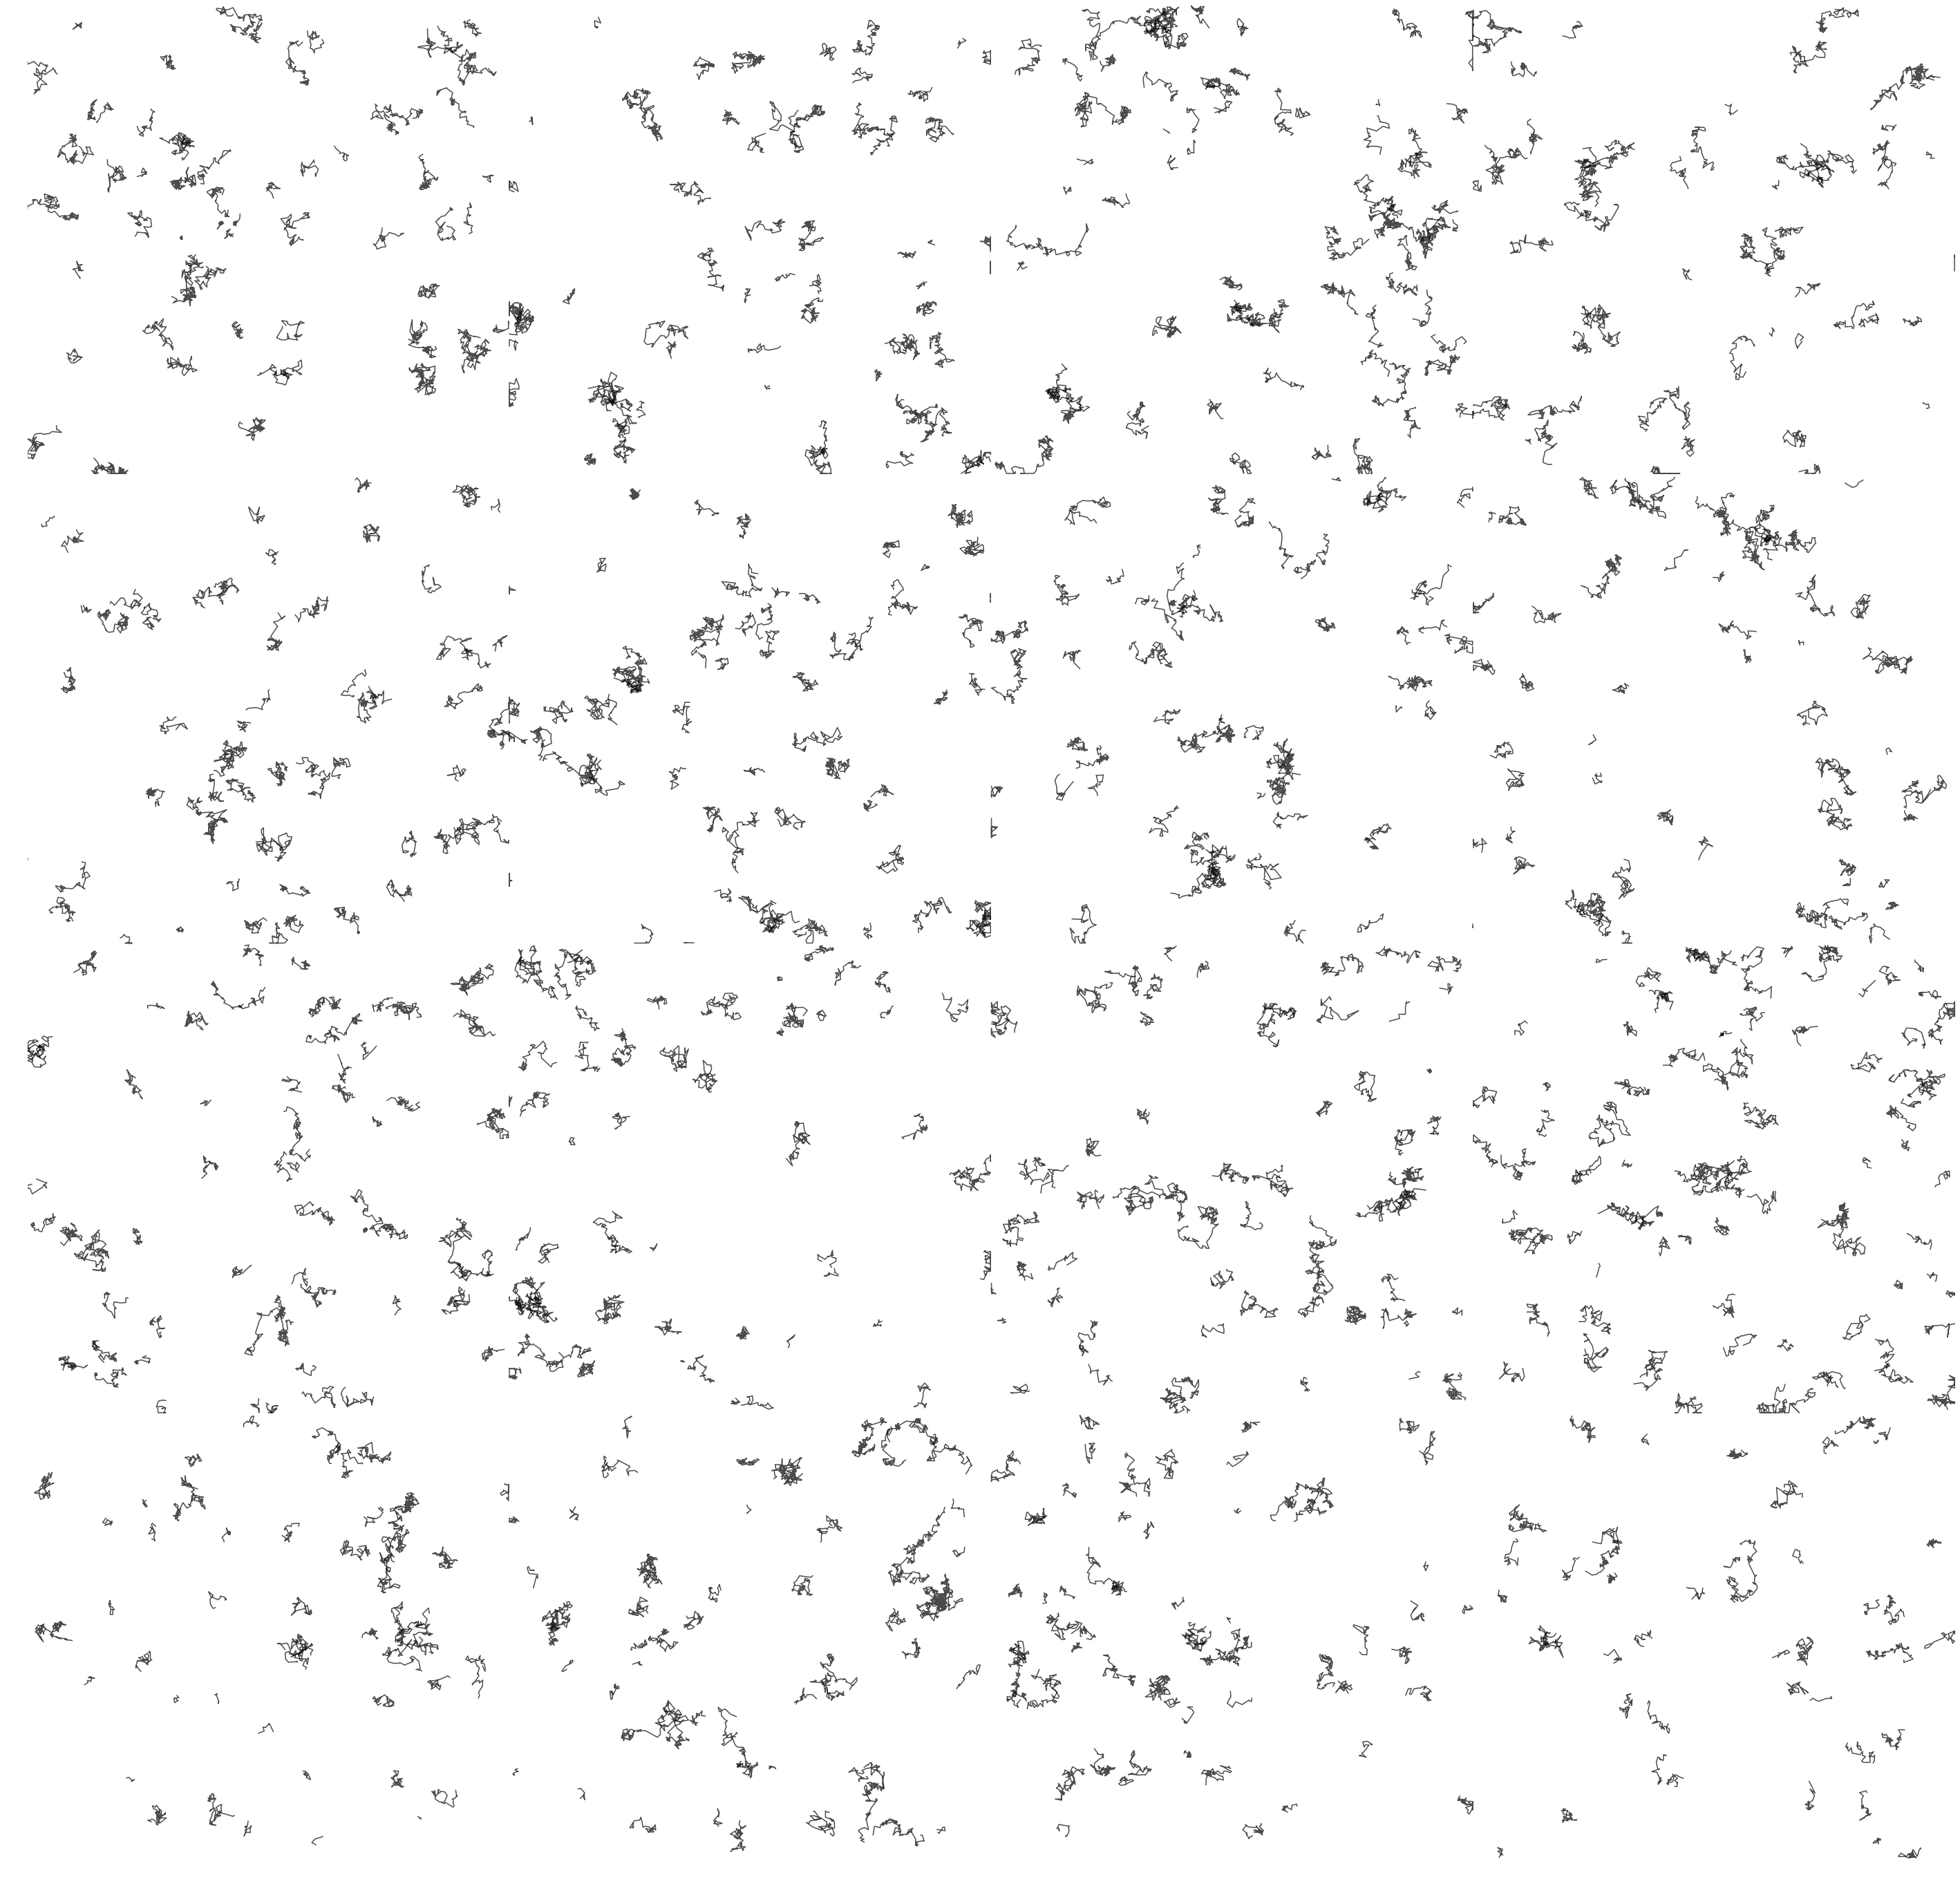

In [16]:
hm.plot_trajectories(prefix, upload=False, figsize=(50,50))

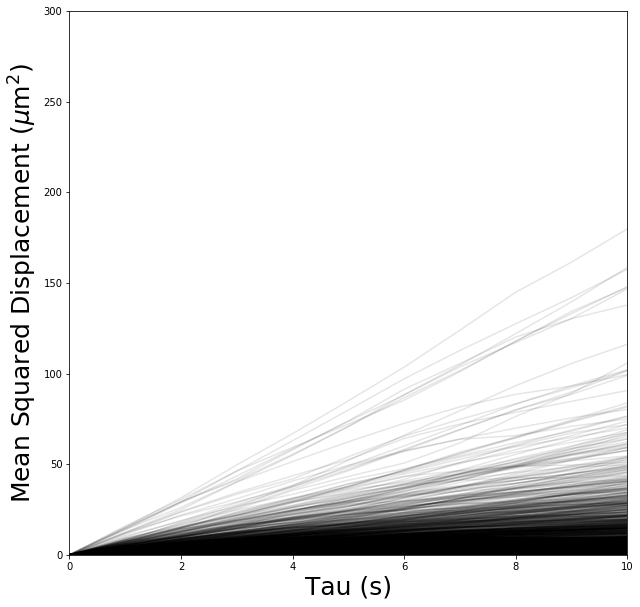

In [16]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=10, y_range=300, alpha=.1, umppx=1, fps=1, upload=False)

In [17]:
plt.plot(x, np.exp(geo_mean), 'k', linewidth=4)

NameError: name 'plt' is not defined

In [112]:

import matplotlib.pyplot as plt


Plotted hiMP_0019 heatmap successfully.


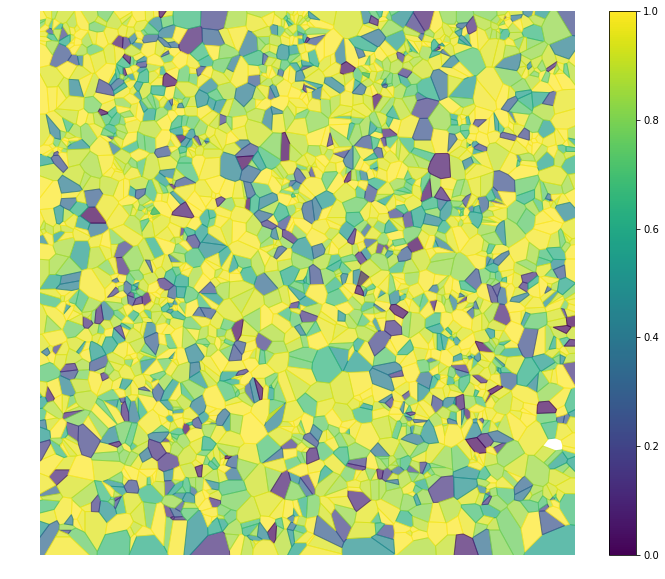

In [96]:
hm.plot_heatmap(prefix, upload=False)

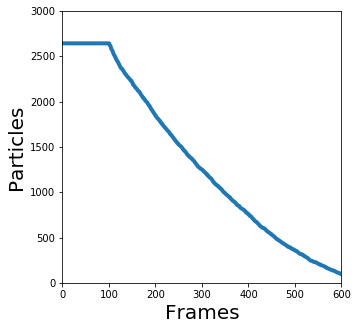

In [102]:
hm.plot_particles_in_frame(prefix, y_range=3000, upload=False)